<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fourmethod/notebooks/Scandal_on_LV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet numpyro dm-haiku==0.0.5 optax

     |████████████████████████████████| 283 kB 13.5 MB/s 
     |████████████████████████████████| 287 kB 75.9 MB/s 
     |████████████████████████████████| 140 kB 89.9 MB/s 
     |████████████████████████████████| 72 kB 635 kB/s 


In [2]:
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git@u/EiffL/numpyro

  Cloning https://github.com/Justinezgh/SBI-Diff-Simulator.git (to revision u/EiffL/numpyro) to /tmp/pip-req-build-t844v4e2
  Running command git clone -q https://github.com/Justinezgh/SBI-Diff-Simulator.git /tmp/pip-req-build-t844v4e2
  Running command git checkout -b u/EiffL/numpyro --track origin/u/EiffL/numpyro
  Switched to a new branch 'u/EiffL/numpyro'
  Branch 'u/EiffL/numpyro' set up to track remote branch 'u/EiffL/numpyro' from 'origin'.
     |████████████████████████████████| 112 kB 14.8 MB/s 
  Created wheel for SBI-Diff-Simulator: filename=SBI_Diff_Simulator-0.0.1-py3-none-any.whl size=6036 sha256=be05d4a341df8ab160eb38e4b363e6c045ea4fe213229e82f8f435861e8337b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0wti9o7/wheels/f0/ae/3c/7c335d538587dcb36fa9a423d7ee6d821bbdf34bad0c5534d3
Successfully built SBI-Diff-Simulator


In [3]:
!pip install chainconsumer

     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for chainconsumer: filename=ChainConsumer-0.33.0-py3-none-any.whl size=42517 sha256=eb914ee5b976111ada9cdf2806c1622a2d02bf8b9215e246fb3d7de86fb66804
  Stored in directory: /root/.cache/pip/wheels/a3/8a/c7/edc35c15c6de91b84dbbc5669ececf0cc07337aa6c524d549c
Successfully built chainconsumer


In [4]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  f

In [5]:
%pylab inline
import arviz as az
az.style.use("arviz-darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [6]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpyro
from numpyro.handlers import seed, trace, condition
from functools import partial

In [7]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [8]:
from sbids.tasks import lotka_volterra, get_samples_and_scores
from sbids.bijectors.bijectors import MixtureAffineSigmoidBijector

## Model with fixed latent variables

In [9]:
from numpyro.infer import MCMC, NUTS, Predictive
from chainconsumer import ChainConsumer

In [10]:
key = jax.random.PRNGKey(0)
lokta_volterra_10 = partial(lotka_volterra, ts=jnp.linspace(0,18.9,5))
lvcond = condition(lokta_volterra_10, {'z':jnp.array([30.0, 1.0])})
(log_probs0, samples0), scores0 = get_samples_and_scores(lvcond, key, batch_size=1,score_type='conditional')
observation0 = samples0['y']
truth0 = samples0['theta']

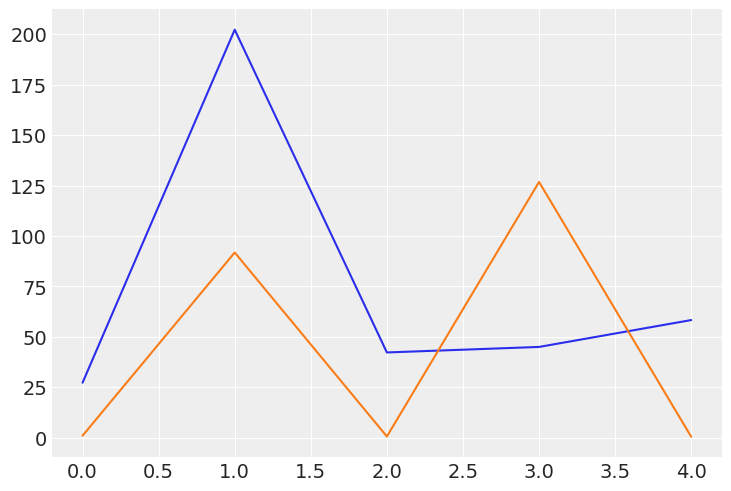

In [11]:
plt.plot(observation0[0])

In [12]:
truth0

DeviceArray([[0.603503  , 0.03026864, 1.6093055 , 0.01722082]], dtype=float32)

In [ ]:
# use dense_mass for better mixing rate
mcmc = MCMC(
    NUTS(lvcond, dense_mass=True,
init_strategy=numpyro.infer.initialization.init_to_sample),
    num_warmup=1000,
    num_samples=10000,
    num_chains=1,
    progress_bar=True,
)
mcmc.run(jax.random.PRNGKey(421), y=observation0) 
mcmc.print_summary()

sample: 100%|██████████| 11000/11000 [00:19<00:00, 555.16it/s, 7 steps of size 5.76e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.58      0.04      0.58      0.51      0.65   5347.43      1.00
  theta[1]      0.03      0.00      0.03      0.02      0.03   6327.06      1.00
  theta[2]      1.65      0.10      1.65      1.50      1.82   6127.06      1.00
  theta[3]      0.02      0.00      0.02      0.01      0.02   5803.66      1.00

Number of divergences: 0


In [ ]:
test_samples_fixed = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


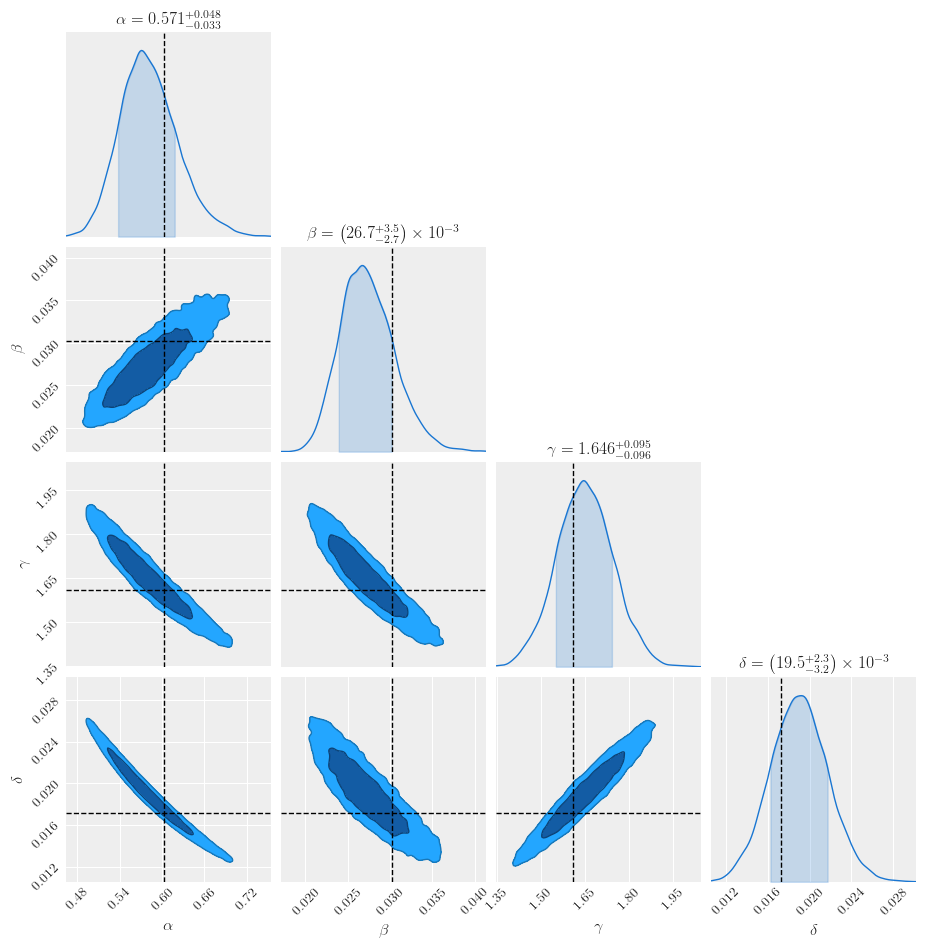

In [ ]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(test_samples_fixed['theta'], parameters=parameters, name="HMC - free z")
fig = c.plotter.plot(figsize=[10,10], truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082])

In [ ]:
jnp.save('posterior_z_fixedkey0',test_samples_fixed['theta'])

In [13]:
test_samples_fixed=jnp.load('/content/posterior_z_fixedkey0-4.npy')

## Data procees

In [14]:
key = jax.random.PRNGKey(30)
(log_probs, samples), scores = get_samples_and_scores(lvcond, key, batch_size=1e4,score_type='conditional')
x1 = samples['y']
x = np.reshape(x1, (-1,10), order='F')
p = samples['theta']

In [15]:
if (x > 500).any() == True:
  idx = jnp.where(x > 500)[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)

if jnp.isnan(x).any() == True:
  idx = jnp.where(jnp.isnan(x))[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)

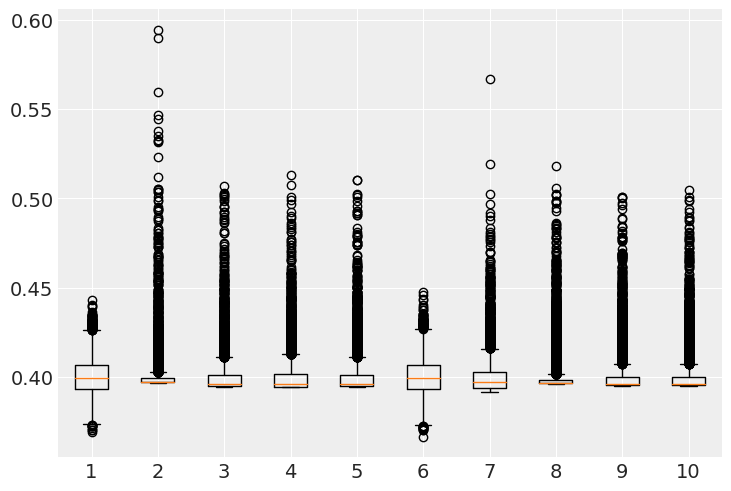

In [16]:
y=x
scale_reg = (jnp.std(y, axis =0)/0.01)
shift_reg = jnp.mean(y/scale_reg, axis = 0)-0.4

normalized_reg = (y/scale_reg) - shift_reg

data = [normalized_reg[...,0],
        normalized_reg[...,1],
        normalized_reg[...,2],
        normalized_reg[...,3],
        normalized_reg[...,4],
        normalized_reg[...,5],
        normalized_reg[...,6],
        normalized_reg[...,7],
        normalized_reg[...,8],
        normalized_reg[...,9],]

plt.boxplot(data);

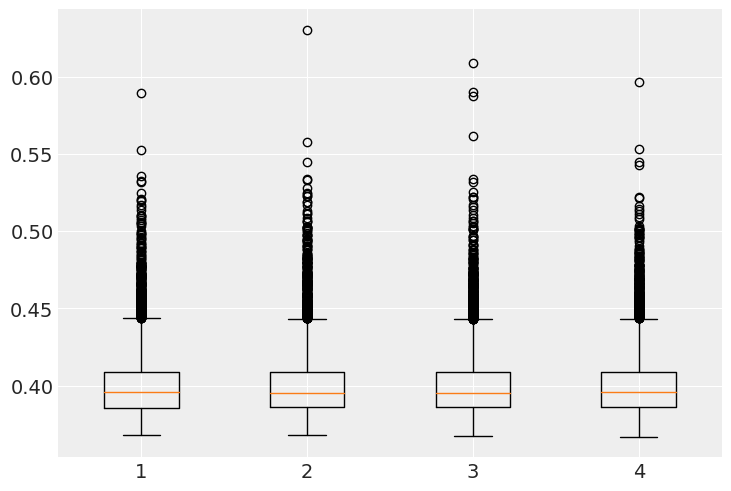

In [17]:
scale_theta = (jnp.std(p, axis =0)/0.02)
shift_theta = jnp.mean(p/scale_theta, axis = 0)-0.4

normalized_p = (p/scale_theta) - shift_theta
data = [normalized_p[...,0],normalized_p[...,1],normalized_p[...,2],normalized_p[...,3]]
plt.boxplot(data);

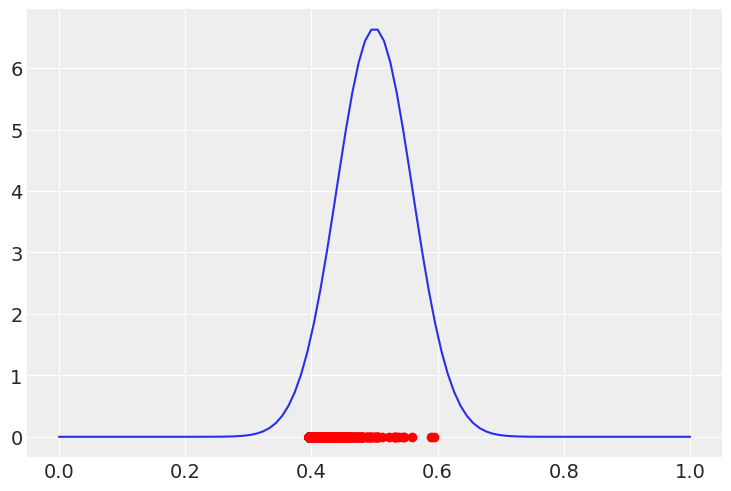

In [18]:
dist = tfd.Normal(0.5*jnp.ones(1), scale=0.06)
xaxe = jnp.linspace(0,1,100)
plt.plot(xaxe,dist.prob(xaxe))
plt.scatter(normalized_reg[...,1],jnp.zeros(len(x)), color = 'r')

## Smooth NF

In [19]:
d = 10

class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, **kwargs):
    self.y = y
    super(CustomCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):
    normalized_p = (self.y/scale_theta) - shift_theta
    net = jnp.concatenate([x,normalized_p], axis=-1)
    #net = x

    # NN to get a b and c
    net = hk.Linear(32, name='l1')(net)
    net = jax.nn.silu(net) 
    net = hk.Linear(64, name='l2')(net)
    net = jax.nn.silu(net) 
    net = hk.Linear(128, name='l3')(net)
    net = jax.nn.silu(net)
    net = hk.Linear(256, name='l4')(net)
    net = jax.nn.silu(net)
    net = hk.Linear(128, name='l5')(net)
    net = jax.nn.silu(net)
    
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 32
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = hk.Linear(output_units*n_components, name='l6')(net)

    log_a = log_a.reshape(-1,output_units,n_components)
    b = b.reshape(-1,output_units,n_components)
    c = c.reshape(-1,output_units,n_components)
    p = p.reshape(-1,output_units,n_components)
    p = jax.nn.softmax(p)


    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c,p)

class Flow_nd(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self, y):
      chain = tfb.Chain([
            tfb.Softplus(),
            tfb.Scale(scale = scale_reg, name='scale1'),
            tfb.Shift(shift = shift_reg, name = 'shift1'),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b1')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b2')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b3')),           
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b4')),           
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b5')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b6')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b7')),           
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(y, name = 'b8')),           
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
        ])
      
      nvp = tfd.TransformedDistribution(
           tfd.MultivariateNormalDiag(0.5*jnp.ones(d), scale_identity_multiplier=0.06),
            bijector=chain)
      
      return nvp

In [20]:
from tqdm import tqdm

In [21]:
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,10])).squeeze()))(mu, batch)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 


@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [22]:
nvp_nd = hk.without_apply_rng(hk.transform(lambda p,x : Flow_nd()(p).log_prob(x).squeeze()))

In [23]:
rng_seq = hk.PRNGSequence(50)
params_smooth = nvp_nd.init(next(rng_seq),  0.4*jnp.ones([1,4]), 0.4*jnp.ones([1,10]))
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=2000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state_smooth = optimizer.init(params_smooth)

In [19]:
key = jax.random.PRNGKey(10)
(log_probs, samples), score = get_samples_and_scores(lvcond, key, batch_size=5e5,score_type='conditional')
batch = samples['y']
batch = np.reshape(batch, (-1,10), order='F')
mu = samples['theta']


if (batch > 500).any() == True:
  idx = jnp.where(batch > 500)[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

if jnp.isnan(batch).any() == True:
  idx = jnp.where(jnp.isnan(batch))[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

In [20]:
  batch_size = 1000
  ntrain = len(batch)
  num_batches = ntrain // batch_size 
  def data_stream():
      """
      Creates a data stream with a predifined batch size.
      """
      rng = np.random.RandomState(0)
      while True:
        perm = rng.permutation(ntrain)
        for i in range(num_batches):
          batch_idx = perm[i * batch_size: (i + 1)*batch_size]
          yield batch[batch_idx], mu[batch_idx], score[batch_idx]

  batches = data_stream()

In [26]:
  losses_smooth = []
  num_epochs = 20
  weight = 0 
  epochs = 0
  
  while epochs < num_epochs: 
    for _ in tqdm(range(num_batches)):
      b,m,s = next(batches)    
      l, params_smooth, opt_state_smooth = update(params_smooth, opt_state_smooth,weight, m,  b, s)
      losses_smooth.append(l)
      

      if jnp.isnan(l)==True:
        print('NAN')
        break

      params_nd_t = params_smooth

    if jnp.isnan(l)==True:
      print('NAN')
      break    
    
      
    epochs +=1

100%|██████████| 497/497 [00:46<00:00, 10.64it/s]


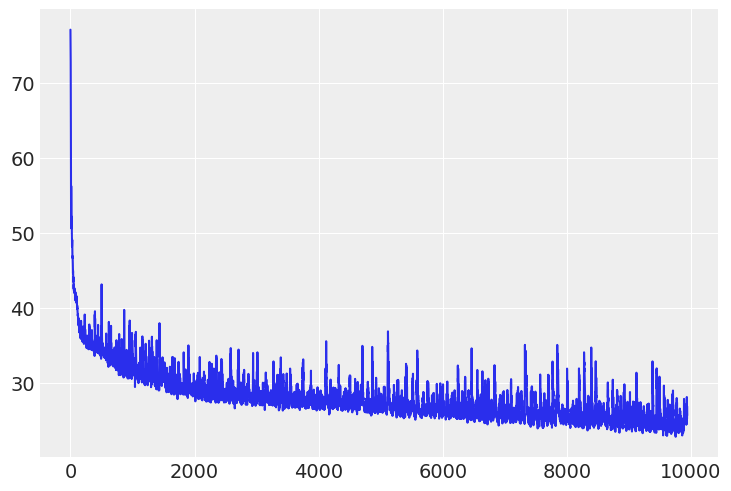

In [27]:
plt.plot(losses_smooth)

In [31]:
observation = np.reshape(observation0, (-1,10), order='F')

In [29]:
@jax.jit
def params_log_prob3(x,observation):
  prior_params = tfd.TransformedDistribution(tfd.Independent(tfd.LogNormal(jnp.array([-0.125,-3,-0.125,-3]), 0.5*jnp.ones(4)),1),
                                            tfb.Invert(tfb.Softplus()))
  theta = tfb.Softplus()(x)
  log_prob = nvp_nd.apply(params_smooth, theta.reshape([1,4]), observation.reshape([1,d]))
  posterior = log_prob
  posterior += prior_params.log_prob(x)
  return posterior

In [30]:
def unnormalized_log_prob(x): 
  return jax.vmap(lambda x: params_log_prob3(x,observation))(x)

# Initialize the HMC transition kernel.
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1e-5)

# To run 100 chains in parallel
init_state = 0.1*jax.random.normal(jax.random.PRNGKey(1), [100, 4])

@jax.jit
def run_chain():
  # Run the chain (with burn-in).
  samples,is_accepted = tfp.mcmc.sample_chain(
      num_results=int(1e3),
      num_burnin_steps=int(3000),
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=jax.random.PRNGKey(60))
  return samples,is_accepted
  
samples_hmc,is_accepted = run_chain() 

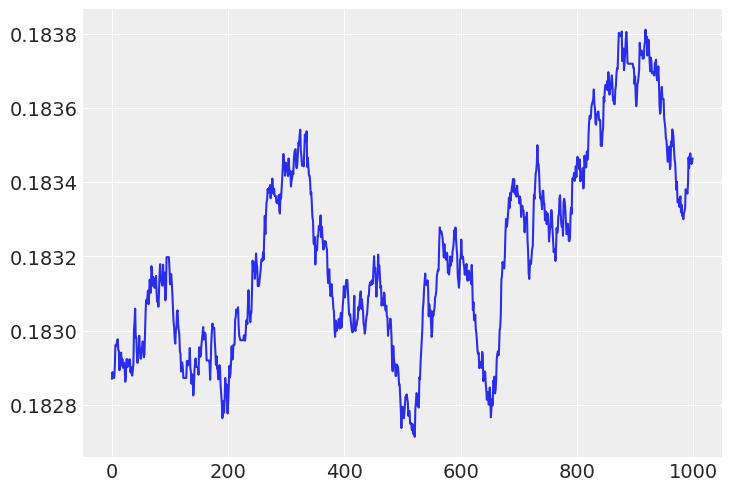

In [31]:
plt.plot(samples_hmc[:,10,2])

In [32]:
sample_smooth = samples_hmc[is_accepted]

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


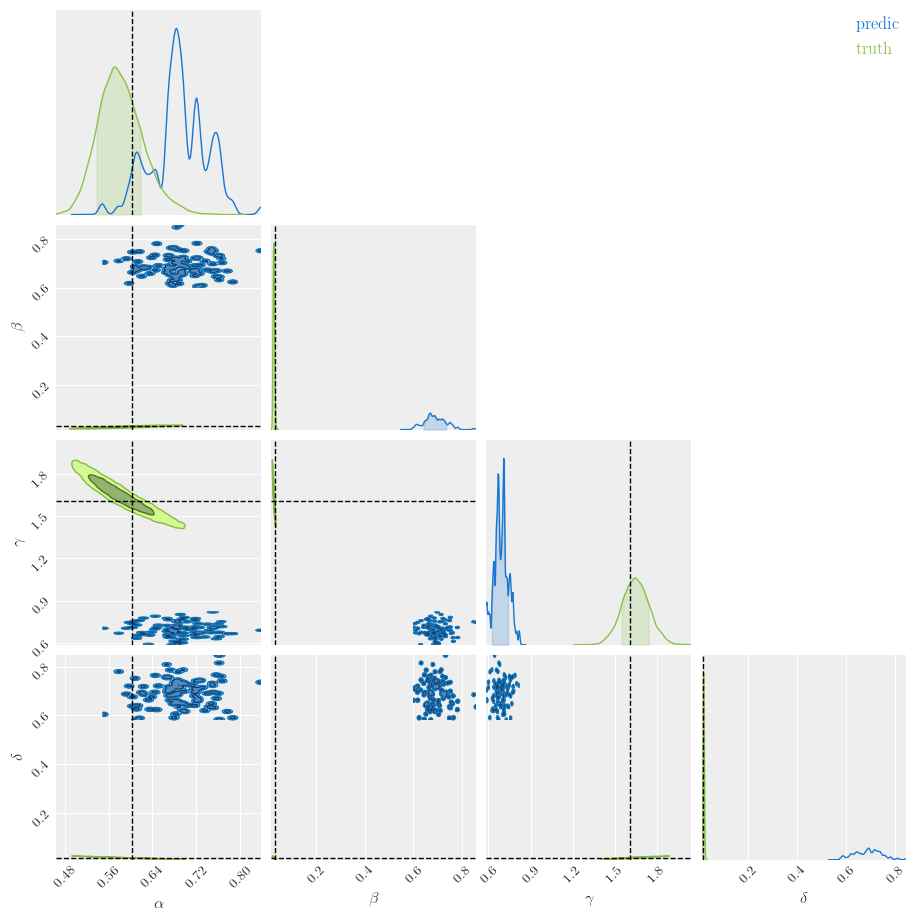

In [33]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()

c.add_chain(tfb.Softplus()(sample_smooth), parameters=parameters, name="predic")
c.add_chain(test_samples_fixed, parameters=parameters, name="truth")
fig = c.plotter.plot(figsize=[10,10], truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082])

## Affine NF 

In [21]:
class AffineCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""

  def __init__(self, y, *args, **kwargs):
    self.y = y
    super(AffineCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):

    normalized_p = (self.y/scale_theta) - shift_theta

    net = jnp.concatenate([x, normalized_p], axis=-1)
    #net = x

    net = hk.Linear(32)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(64)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(256)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    shifter = tfb.Shift(hk.Linear(output_units)(net))
    scaler = tfb.Scale(jnp.clip(jnp.exp(hk.Linear(output_units)(net)), 1e-2, 1e2))
    
    return tfb.Chain([shifter, scaler])   



d = 10

class AffineFlow(hk.Module):
    """This is a normalizing flow using the coupling layers defined
    above."""
    def __call__(self,y):
      
        chain = tfb.Chain([
            #tfb.Softplus(),
            tfb.Scale(scale = scale_reg, name='scale1'),
            tfb.Shift(shift = shift_reg, name = 'shift1'),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff1')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff2')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff3')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff3')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff4')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff5')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff6')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff7')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(y, name='aff8')),
            tfb.Permute([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]),
        ])
        
        nvp = tfd.TransformedDistribution(
           tfd.MultivariateNormalDiag(0.5*jnp.ones(d), scale_identity_multiplier=0.06),
            bijector=chain)
        
        return nvp

In [22]:
affine_model = hk.without_apply_rng(hk.transform(lambda p,x : AffineFlow()(p).log_prob(x).squeeze()))

In [23]:
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: affine_model.apply(params, theta.reshape([1,4]), x.reshape([1,d])).squeeze()))(mu, batch)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 


@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [24]:
rng_seq = hk.PRNGSequence(798)
params_affine = affine_model.init(next(rng_seq),  0.4*jnp.ones([1,4]), 0.4*jnp.ones([1,d]))
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=2000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state_affine = optimizer.init(params_affine)

In [26]:
from tqdm import tqdm

In [27]:
  losses = []
  num_epochs = 20
  weight = 0 
  epochs = 0
  
  while epochs < num_epochs: 
    for _ in tqdm(range(num_batches)):
      b,m,s = next(batches)    
      l, params_affine, opt_state_affine = update(params_affine, opt_state_affine,weight, m,  b, s)
      losses.append(l)
      

      if jnp.isnan(l)==True:
        print('NAN')
        break

      params_affine_t = params_affine

    if jnp.isnan(l)==True:
      print('NAN')
      break    
    
      
    epochs +=1

100%|██████████| 497/497 [00:09<00:00, 52.46it/s]


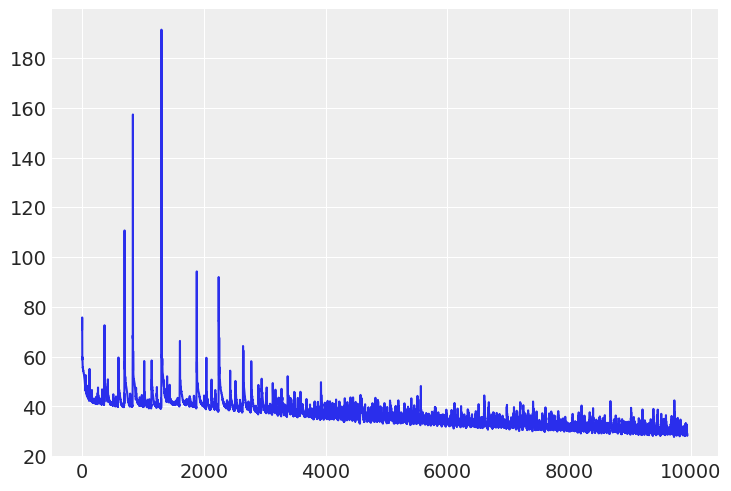

In [28]:
plt.plot(losses)

In [32]:
@jax.jit
def params_log_prob(x,observation):
  prior_params = tfd.TransformedDistribution(tfd.Independent(tfd.LogNormal(jnp.array([-0.125,-3,-0.125,-3]), 0.5*jnp.ones(4)),1),
                                            tfb.Invert(tfb.Softplus()))
  theta = tfb.Softplus()(x)
  log_prob = affine_model.apply(params_affine, theta.reshape([1,4]), observation.reshape([1,d]))
  posterior = log_prob
  posterior += prior_params.log_prob(x)
  return posterior

In [33]:
def unnormalized_log_prob2(x): 
  return jax.vmap(lambda x: params_log_prob(x,observation))(x)

# Initialize the HMC transition kernel.
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob2,
        num_leapfrog_steps=3,
        step_size=1e-5)

# To run 100 chains in parallel
init_state = 0.1*jax.random.normal(jax.random.PRNGKey(1), [100, 4])

@jax.jit
def run_chain2():
  # Run the chain (with burn-in).
  samples,is_accepted = tfp.mcmc.sample_chain(
      num_results=int(1e4),
      num_burnin_steps=int(3000),
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=jax.random.PRNGKey(60))
  return samples,is_accepted
  
samples_hmc,is_accepted = run_chain2() 

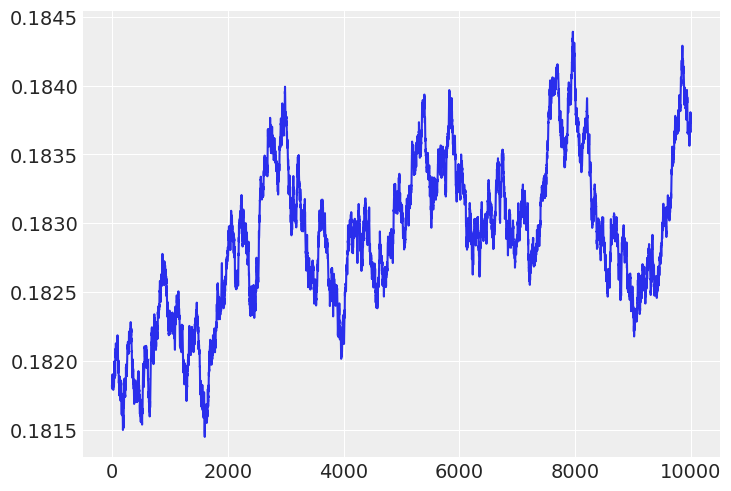

In [34]:
plt.plot(samples_hmc[:,10,2])

In [35]:
sample_nd = samples_hmc[is_accepted]

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


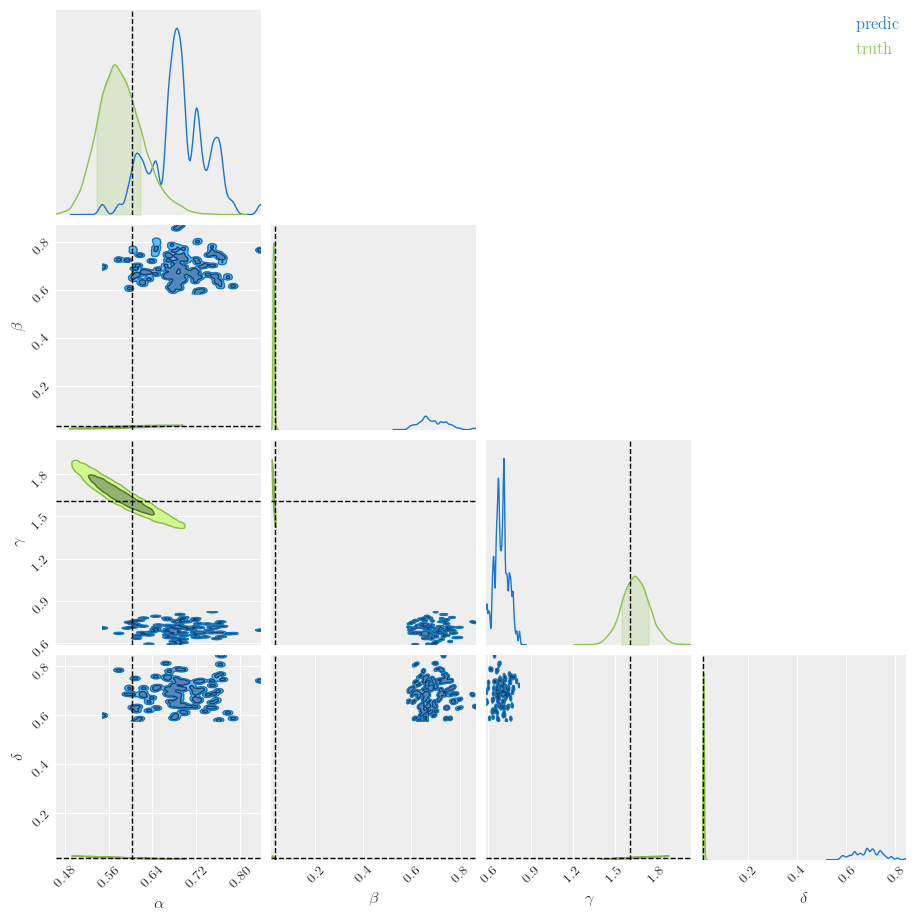

In [36]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()

c.add_chain(tfb.Softplus()(sample_nd), parameters=parameters, name="predic")
c.add_chain(test_samples_fixed, parameters=parameters, name="truth")
fig = c.plotter.plot(figsize=[10,10], truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082])